## Importaciones

In [40]:
import os
import time
import math
import pandas as pd
from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from modules.labeling_lib import get_labels_one_direction
from modules.labeling_lib import sliding_window_clustering
from modules.tester_lib import tester_one_direction
from modules.export_lib import export_model_to_ONNX
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
# Obtener precios
def get_prices(hyper_params) -> pd.DataFrame:
    history_file = os.path.join(hyper_params["history_path"], f"{hyper_params['symbol']}_{hyper_params['timeframe']}.csv")
    p = pd.read_csv(history_file, sep=r"\s+")
    pFixed = pd.DataFrame(columns=['time', 'close'])
    pFixed['time'] = p['<DATE>'] + ' ' + p['<TIME>']
    pFixed['time'] = pd.to_datetime(pFixed['time'], format='mixed')
    pFixed['close'] = p['<CLOSE>']
    pFixed.set_index('time', inplace=True)
    return pFixed.dropna()
# Ingeniería de características
def get_features(data, hyper_params):
    pFixed = data.copy()
    pFixedC = data.copy()
    count = 0
    for i in hyper_params['periods']:
        pFixed[str(count)] = pFixedC.rolling(i).std(ddof=1).shift(1)
        count += 1
    for i in hyper_params['periods_meta']:
        pFixed[str(count)+'meta_feature'] = pFixedC.rolling(i).std(ddof=1).shift(1)
        count += 1
    return pFixed.dropna()
def fit_final_models(clustered, meta, oos_data, hyper_params) -> list:
    # features for model\meta models. We learn main model only on filtered labels 
    X, X_meta = clustered[clustered.columns[:-1]], meta[meta.columns[:-1]]
    X = X.loc[:, ~X.columns.str.contains('meta_feature')]
    X_meta = X_meta.loc[:, X_meta.columns.str.contains('meta_feature')]
    
    # labels for model\meta models
    y = clustered['labels']
    y_meta = meta['clusters']
    
    y = y.astype('int16')
    y_meta = y_meta.astype('int16')

    # train\test split
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, train_size=0.7, test_size=0.3, shuffle=True)
    
    train_X_m, test_X_m, train_y_m, test_y_m = train_test_split(
        X_meta, y_meta, train_size=0.7, test_size=0.3, shuffle=True)


    # learn main model with train and validation subsets
    model = CatBoostClassifier(iterations=500,
                               custom_loss=['Accuracy'],
                               eval_metric='Accuracy',
                               verbose=False,
                               use_best_model=True,
                               task_type='CPU',
                               thread_count=-1)
    model.fit(train_X, train_y, eval_set=(test_X, test_y),
              early_stopping_rounds=25, plot=False)
    
    # learn meta model with train and validation subsets
    meta_model = CatBoostClassifier(iterations=300,
                                    custom_loss=['F1'],
                                    eval_metric='F1',
                                    verbose=False,
                                    use_best_model=True,
                                    task_type='CPU',
                                    thread_count=-1)
    meta_model.fit(train_X_m, train_y_m, eval_set=(test_X_m, test_y_m),
              early_stopping_rounds=15, plot=False)

    
    R2 = test_model_one_direction(
        oos_data,                 # <- solo datos fuera de muestra
        [0, model, meta_model],
        hyper_params['stop_loss'],
        hyper_params['take_profit'],
        hyper_params['full forward'],
        hyper_params['forward'],
        hyper_params['markup'],
        hyper_params['direction'],
        plt=False)
    if math.isnan(R2):
        R2 = -1.0
        print('R2 is fixed to -1.0')
    print('R2: ' + str(R2))

    return [R2, model, meta_model]
def test_model_one_direction(
        dataset: pd.DataFrame,        #  ← nuevo
        result:  list,
        stop:    float,
        take:    float,
        forward: datetime,
        backward: datetime,
        markup:  float,
        direction: str,
        plt: bool = False):

    pr_tst = dataset.copy()           # ahora usamos el dataset recibido
    X      = pr_tst[pr_tst.columns[1:]]
    X_meta = X.loc[:,  X.columns.str.contains('meta_feature')]
    X      = X.loc[:, ~X.columns.str.contains('meta_feature')]

    pr_tst['labels']      = result[1].predict_proba(X)[:,1]
    pr_tst['meta_labels'] = result[2].predict_proba(X_meta)[:,1]
    pr_tst[['labels','meta_labels']] = pr_tst[['labels','meta_labels']].map(
                                       lambda x: 0.0 if x < 0.5 else 1.0)

    return tester_one_direction(pr_tst, stop, take, forward,
                                backward, markup, direction, plt)

## Main

too few samples: 361
Iteration: 0, Cluster: 1.0
R2: 0.18196744010844468
Iteration: 0, Cluster: 2.0
R2: 0.9171630475933582
Iteration: 0, Cluster: 3.0
R2: 0.22147322977039152
Iteration: 0, Cluster: 4.0
R2: 0.05417450852309125
too few samples: 119
Iteration: 0, Cluster: 6.0
R2: 0.16209257656158116
too few samples: 30
Iteration: 0, Cluster: 8.0
R2: -0.0015798657760264234
Iteration: 0, Cluster: 9.0
R2: -0.4571311704909913
too few samples: 342


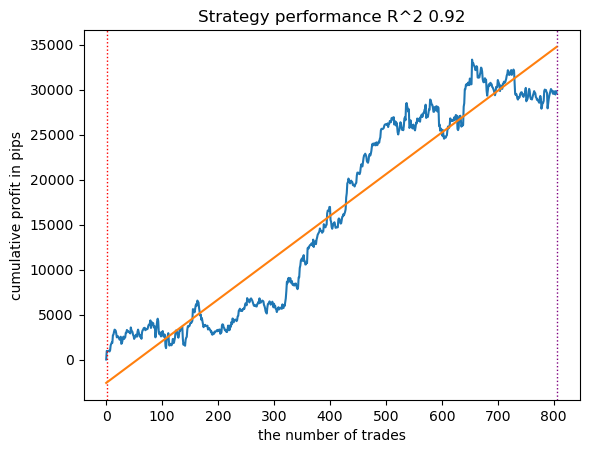

Modelos a exportar: [0.9171630475933582, <catboost.core.CatBoostClassifier object at 0x7fd94dddeed0>, <catboost.core.CatBoostClassifier object at 0x7fd94ddde900>]
Modelo /mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Files/dmitrievsky_model_BTCUSDT_H1_0.onnx ONNX exportado correctamente
Modelo /mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Files/dmitrievsky_model_m_BTCUSDT_H1_0.onnx ONNX exportado correctamente
The file /mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Include/ajmtrz/include/Dmitrievsky/BTCUSDT_H1_ONNX_include_0.mqh has been written to disk


In [42]:
def main(symbol, timeframe):
    common_file_folder = r"/mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/Common/Files/"
    mql5_files_folder = r'/mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Files/'
    mql5_include_folder = r'/mnt/c/Users/Administrador/AppData/Roaming/MetaQuotes/Terminal/6C3C6A11D1C3791DD4DBF45421BF8028/MQL5/Include/ajmtrz/include/Dmitrievsky'
    hyper_params = {
        'symbol': symbol,
        'timeframe': timeframe,
        'models_export_path': mql5_files_folder,
        'include_export_path': mql5_include_folder,
        'history_path': common_file_folder,
        'best_models': [],
        'model_number': 0,
        'markup': 0.20,
        'stop_loss':  10.0000,
        'take_profit': 5.0000,
        'direction': 'buy',
        'n_clusters': 10,
        'window_size': 200,
        'periods': [i for i in range(5, 300, 30)][::-1],
        'periods_meta': [5],
        'backward': datetime(2018, 3, 19),
        'forward': datetime(2024, 1, 1),
        'full forward': datetime(2026, 1, 1),
    }
    # LEARNING LOOP
    full_ds  = get_features(get_prices(hyper_params), hyper_params)
    ds_train = full_ds[(full_ds.index >  hyper_params['backward']) &     # in‑sample
                    (full_ds.index <  hyper_params['forward'])]
    ds_oos   = full_ds[(full_ds.index >= hyper_params['forward']) &       # out‑sample
                    (full_ds.index <  hyper_params['full forward'])]
    models = []
    for i in range(1):
        start_time = time.time()
        data = sliding_window_clustering(ds_train,
                                 n_clusters=hyper_params['n_clusters'],
                                 window_size=hyper_params['window_size'])
        sorted_clusters = data['clusters'].unique()
        sorted_clusters.sort()
        for clust in sorted_clusters:
            clustered_data = data[data['clusters'] == clust].copy()
            if len(clustered_data) < 500:
                print('too few samples: {}'.format(len(clustered_data)))
                continue
        
            clustered_data = get_labels_one_direction(clustered_data,
                                           markup=hyper_params['markup'],
                                           min=1,
                                           max=15,
                                           direction=hyper_params['direction'])
            
            print(f'Iteration: {i}, Cluster: {clust}')
            clustered_data = clustered_data.drop(['close', 'clusters'], axis=1)

            meta_data = data.copy()
            meta_data['clusters'] = meta_data['clusters'].apply(lambda x: 1 if x == clust else 0)
            models.append(
                fit_final_models(clustered_data,
                                meta_data.drop(['close'], axis=1),
                                ds_oos,                    # ← NUEVO
                                hyper_params))
        hyper_params['best_models'] = max(models, key=lambda x: x[0])
        test_model_one_direction(ds_oos,
            hyper_params['best_models'],            # mejores modelos
            hyper_params['stop_loss'],
            hyper_params['take_profit'],
            hyper_params['full forward'],
            hyper_params['forward'],
            hyper_params['markup'],
            hyper_params['direction'],
            plt=True)
        print("Modelos a exportar:", hyper_params['best_models'])
        export_model_to_ONNX(**hyper_params)

if __name__ == "__main__":
    main('BTCUSDT', 'H1')